In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
import os, codecs
%matplotlib inline
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn import metrics as skmetrics
import seaborn as sns; sns.set()
import scipy.stats

2017-08-12 14:17:51,505 : INFO : 'pattern' package found; tag filters are available for English
/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_rows', 5000)
pd.reset_option('display.max_rows')

## Model 1 evaluation

In [3]:
df = pd.read_csv('~/personality-normalized-single-file-word2vec.csv', encoding='utf-8')
df.shape

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(238970, 186)

In [4]:
liwc_attr = ['X1funct' ,'X2pronoun' ,'X3ppron','X4i','X5we','X6you','X7shehe','X8they','X9ipron','X10article','X11verb','X12auxverb','X13past','X14present','X15future','X16adverb','X17preps','X18conj','X19negate','X20quant','X21number','X22swear','X23social','X24family','X25friend','X26humans','X27affect','X28posemo','X29negemo','X30anx','X31anger','X32sad','X33cogmech','X34insight','X35cause','X36discrep','X37tentat','X38certain','X39inhib','X40incl','X41excl','X42percept','X43see','X44hear','X45feel','X46bio','X47body','X48health','X49sexual','X50ingest','X51relativ','X52motion','X53space','X54time','X55work','X56achieve','X57leisure','X58home','X59money','X60relig','X61death','X62assent','X63nonfl', 'X64filler']

In [5]:
df = df.convert_objects(convert_numeric=True)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [6]:
psico = pd.read_csv('/home/bahbbc/Downloads/psycholinguistic_properties/BP.csv', encoding='utf-8')

In [7]:
psico.head()

Word Simplified grammatical category  Concretenes  \
0     abafado                               a         3.47   
1    abafador                               a         5.73   
2     abalado                               a         2.61   
3   abalizado                               a         3.88   
4  abandonado                               a         3.68   

   Subjective Frequency  Imagery   AoA  Log frequency  Frequency  
0                  3.92     3.96  5.28           7.11     1220.0  
1                  2.84     5.10  7.25           4.41       82.0  
2                  4.12     3.59  7.62           8.15     3450.0  
3                  2.58     3.56  7.59           4.36       78.0  
4                  4.16     3.97  5.24           9.75    17183.0

In [8]:
concreteness = dict(zip(psico.Word, psico.Concretenes))
subjective_freq = dict(zip(psico.Word, psico['Subjective Frequency']))
imagery = dict(zip(psico.Word, psico.Imagery))
aoa =  dict(zip(psico.Word, psico.AoA))
log_freq = dict(zip(psico.Word, psico['Log frequency']))
freq = dict(zip(psico.Word, psico.Frequency))

In [9]:
df.extraversion_m.value_counts()

0    121670
1    117300
Name: extraversion_m, dtype: int64

In [10]:
train_w2v_data, test_w2v_data = train_test_split(df, test_size=0.3, random_state=42)

In [11]:
def remove_nan(atributes):
    train_attr = np.array(train_w2v_data[atributes])
    test_attr = np.array(test_w2v_data[atributes])
    train_attr[np.isnan(train_attr)] = 0
    test_attr[np.isnan(test_attr)] = 0
    return (train_attr, test_attr)

In [12]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['formatted_text'])
    predictions = classifier.predict(data_features)
    target = data['extraversion_m']
    evaluate_prediction(predictions, target)

In [13]:
def makeFeatureVec(words, psico_dict):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = 0.
    #
    nwords = 0.
    
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if (word in psico_dict):
            nwords = nwords + 1.
            featureVec = featureVec + psico_dict[word]
    # 
    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = featureVec / nwords
    else:
        print 'sorry, empty...'
    return featureVec


def getAvgFeatureVecs(reviews, psico_dict):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews)),dtype="float32")
    # 
    # Loop through the reviews
    for review in reviews:
        #Print a status message every 1000th review
        if counter%100. == 0.:
            print "Review %d of %d" % (counter, len(reviews))
        #Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, psico_dict)
        #Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

In [14]:
def w2v_tokenize_text(text):
    tokens = []
    if text is np.nan:
        return []
    for sent in nltk.sent_tokenize(text, language='portuguese'):
        for word in nltk.word_tokenize(sent, language='portuguese'):
            word = word.lower()
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [15]:
train, test = remove_nan(liwc_attr)

In [16]:
test_tokenized = test_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_w2v_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [17]:
index = pd.isnull(train_w2v_data.formatted_text)
train_w2v_data.loc[index, 'formatted_text'] = ''

/usr/lib64/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
concreteness = dict(zip(psico.Word, psico.Concretenes))
subjective_freq = dict(zip(psico.Word, psico['Subjective Frequency']))
imagery = dict(zip(psico.Word, psico.Imagery))
aoa =  dict(zip(psico.Word, psico.AoA))
log_freq = dict(zip(psico.Word, psico['Log frequency']))
freq = dict(zip(psico.Word, psico.Frequency))

In [19]:
conc_trainDataVecs = getAvgFeatureVecs( train_tokenized, concreteness )
conc_testDataVecs = getAvgFeatureVecs( test_tokenized, concreteness )
sub_trainDataVecs = getAvgFeatureVecs( train_tokenized, subjective_freq )
sub_testDataVecs = getAvgFeatureVecs( test_tokenized, subjective_freq )
ima_trainDataVecs = getAvgFeatureVecs( train_tokenized, imagery )
ima_testDataVecs = getAvgFeatureVecs( test_tokenized, imagery )
aoa_trainDataVecs = getAvgFeatureVecs( train_tokenized, aoa )
aoa_testDataVecs = getAvgFeatureVecs( test_tokenized, aoa )

Review 0 of 167279
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
Review 100 of 167279
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...
sorry, empty...


In [20]:
train_data = np.vstack((conc_trainDataVecs,sub_trainDataVecs, ima_trainDataVecs, aoa_trainDataVecs))

In [21]:
train_data = train_data.T
train_data = pd.DataFrame(train_data, index=train_w2v_data.index, columns=['concreteness', 'subjective_freq', 'imagery', 'aoa'])
train = pd.DataFrame(train, index=train_w2v_data.index, columns=liwc_attr)

In [22]:
train_features = pd.concat([train_data, train], axis=1)

In [23]:
test_data = np.vstack((conc_testDataVecs, sub_testDataVecs, ima_testDataVecs, aoa_testDataVecs))

In [24]:
test_data = test_data.T
test_data = pd.DataFrame(test_data, index=test_w2v_data.index, columns=['concreteness', 'subjective_freq', 'imagery', 'aoa'])
test = pd.DataFrame(test, index=test_w2v_data.index, columns=liwc_attr)

In [25]:
test_features = pd.concat([test_data, test], axis=1)

# Correlation heatmap

In [26]:
correlation_attr = train_features.append(test_features)

extr = train_w2v_data.extraversion.append(test_w2v_data.extraversion)
agre = train_w2v_data.agreeableness.append(test_w2v_data.agreeableness)
cons = train_w2v_data.conscientiousness.append(test_w2v_data.conscientiousness)
neur = train_w2v_data.neuroticism.append(test_w2v_data.neuroticism)
openn = train_w2v_data.openness.append(test_w2v_data.openness)

personality_data = pd.DataFrame({'extr': extr, 'agre':agre, 'cons':cons, 'neur':neur, 'open':openn})

correlation_attr = pd.concat([correlation_attr, personality_data], axis=1)

In [27]:
corr = correlation_attr.corr()

In [28]:
corr['extr'][abs(corr['extr']) > 0.2]

X24family    0.200734
X28posemo    0.218339
extr         1.000000
open         0.215956
Name: extr, dtype: float64

In [29]:
corr['agre'][abs(corr['agre']) > 0.15]

X27affect    0.150022
X28posemo    0.194398
agre         1.000000
cons         0.184472
extr         0.193474
neur        -0.348070
Name: agre, dtype: float64

In [30]:
corr['cons'][abs(corr['cons']) > 0.15]

X28posemo    0.181192
X54time      0.155339
agre         0.184472
cons         1.000000
extr         0.155086
Name: cons, dtype: float64

In [31]:
corr['neur'][abs(corr['neur']) > 0.15]

X4i     0.172642
agre   -0.348070
extr   -0.163381
neur    1.000000
Name: neur, dtype: float64

In [32]:
corr['open'][abs(corr['open']) > 0.15]

extr    0.215956
open    1.000000
Name: open, dtype: float64

In [33]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

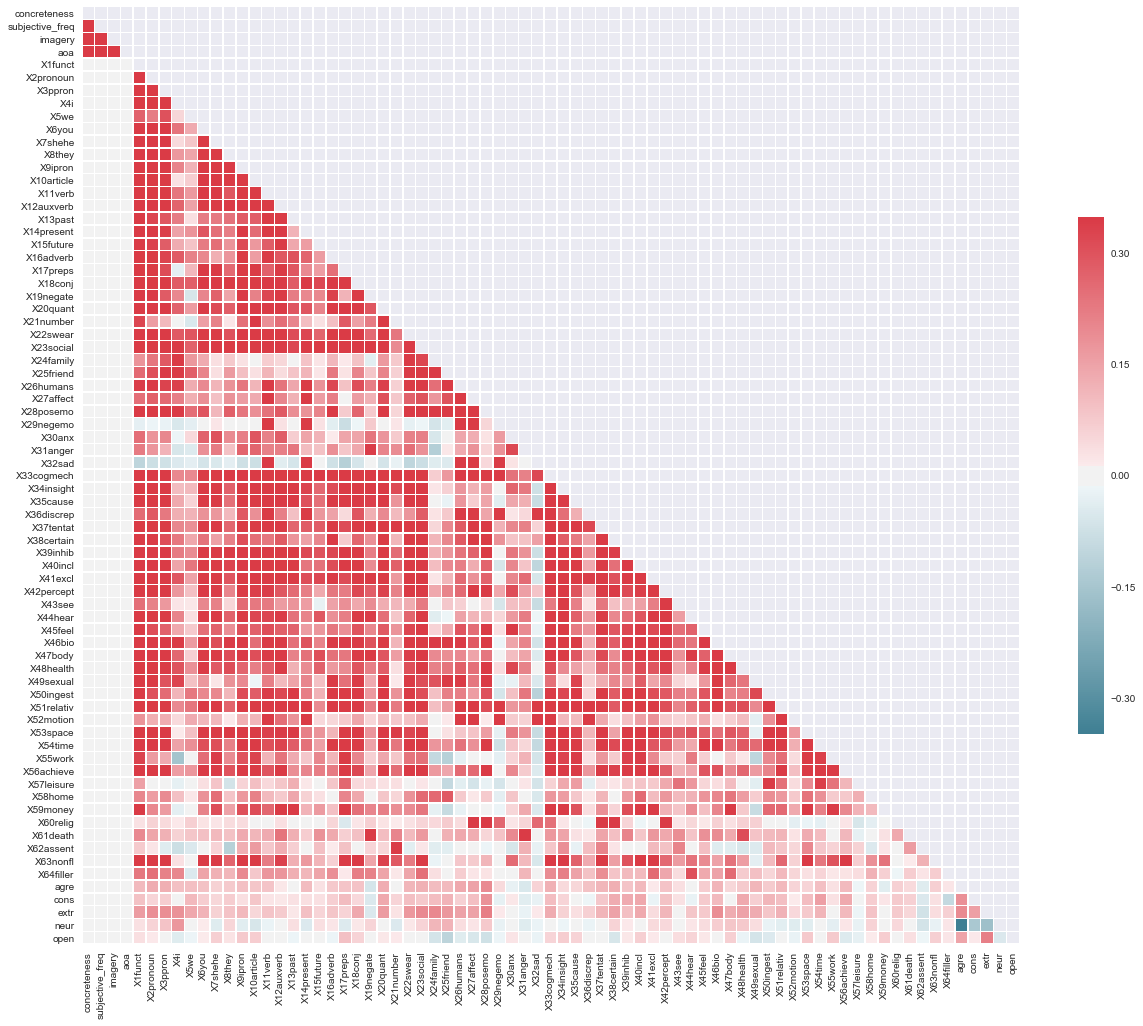

In [34]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(21, 19))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals import joblib

force = False
model_trainer = RandomizedSearchCV(
    n_iter=1, 
    estimator=DecisionTreeRegressor(),
    param_distributions={
        "max_features": ["log2"],
        "random_state": [42],
        "criterion":['mse']
    },
    verbose=True,
    refit=True,
    cv=10,
    n_jobs=-1
)

## Extraversion

In [36]:
%%time
model_trainer.fit(train_features, train_w2v_data['extraversion'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.1s finished


CPU times: user 2.4 s, sys: 198 ms, total: 2.6 s
Wall time: 22.1 s


In [37]:
yp = model.predict(test_features)
yt = test_w2v_data['extraversion']

In [38]:
skmetrics.mean_squared_error(yt, yp)

0.0087698518752142782

In [39]:
skmetrics.r2_score(yt, yp)

0.98753756570897888

In [40]:
skmetrics.mean_squared_error(yt, yp)**0.5

0.093647487287242676

In [41]:
names = test_features.keys()
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.0574, 'X26humans'), (0.0454, 'X12auxverb'), (0.0383, 'X8they'), (0.0321, 'X1funct'), (0.0317, 'X38certain'), (0.0286, 'X37tentat'), (0.0271, 'X16adverb'), (0.0258, 'X14present'), (0.0252, 'X51relativ'), (0.0236, 'X62assent'), (0.0235, 'X9ipron'), (0.0235, 'X27affect'), (0.0228, 'X29negemo'), (0.0226, 'X24family'), (0.0208, 'X59money'), (0.0202, 'X58home'), (0.0201, 'X10article'), (0.0198, 'X61death'), (0.0191, 'X45feel'), (0.0188, 'X23social'), (0.0181, 'X64filler'), (0.018, 'X25friend'), (0.017, 'X3ppron'), (0.0164, 'X31anger'), (0.0158, 'X60relig'), (0.0155, 'X48health'), (0.0149, 'X34insight'), (0.0149, 'X15future'), (0.0148, 'X30anx'), (0.0147, 'X54time'), (0.0146, 'X56achieve'), (0.0144, 'X19negate'), (0.0139, 'X57leisure'), (0.0136, 'X13past'), (0.0132, 'X6you'), (0.0129, 'X43see'), (0.0124, 'X28posemo'), (0.0124, 'X11verb'), (0.012, 'X20quant'), (0.0115, 'X50ingest'), (0.0115, 'X21number'), (0.0112, 'X41excl'), (0.0109, 'X36discrep'), (0.0103,

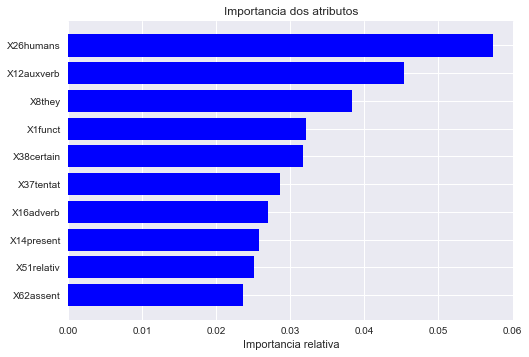

In [42]:
features = test_features.keys()
importances = model.feature_importances_

indices = np.argsort(importances)[-10:]

plt.title('Importancia dos atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importancia relativa')
plt.show()

## Agreableness

In [43]:
%%time
model_trainer.fit(train_features, train_w2v_data['agreeableness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.5s finished


CPU times: user 2.31 s, sys: 251 ms, total: 2.56 s
Wall time: 6.36 s


In [ ]:
yp = model.predict(test_features)
yt = test_w2v_data['agreeableness']

In [ ]:
skmetrics.mean_squared_error(yt, yp)

0.0034407816441454071

In [ ]:
skmetrics.r2_score(yt, yp)

In [ ]:
skmetrics.mean_squared_error(yt, yp)**0.5

In [ ]:
names = test_features.keys()
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True)

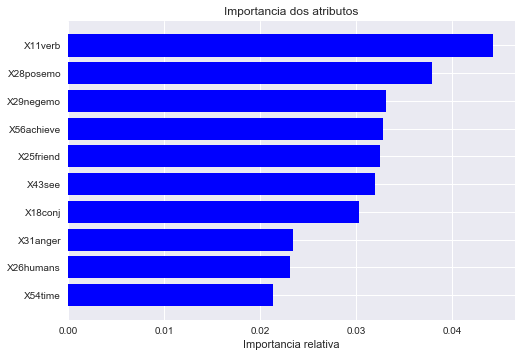

In [50]:
features = test_features.keys()
importances = model.feature_importances_

indices = np.argsort(importances)[-10:]

plt.title('Importancia dos atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importancia relativa')
plt.show()

## Conscientiousness

In [135]:
%%time
model_trainer.fit(train_features, train_w2v_data['conscientiousness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 165 ms, sys: 64 ms, total: 229 ms
Wall time: 290 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [136]:
yp = model.predict(test_features)
yt = test_w2v_data['conscientiousness']

In [137]:
skmetrics.mean_squared_error(yt, yp)

0.77078929286858988

In [138]:
skmetrics.r2_score(yt, yp)

-1.0033941235423702

In [139]:
skmetrics.mean_squared_error(yt, yp)**0.5

0.87794606489726346

In [140]:
names = test_features.keys()
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.053, 'X39inhib'), (0.0405, 'X27affect'), (0.0403, 'X21number'), (0.0337, 'X47body'), (0.0334, 'X60relig'), (0.0327, 'X56achieve'), (0.0314, 'X24family'), (0.0293, 'X42percept'), (0.028, 'X22swear'), (0.0249, 'X31anger'), (0.024, 'X1funct'), (0.0235, 'X53space'), (0.0235, 'X3ppron'), (0.0233, 'X44hear'), (0.0228, 'X9ipron'), (0.0225, 'X59money'), (0.021, 'X41excl'), (0.0202, 'X12auxverb'), (0.0197, 'X18conj'), (0.0193, 'X40incl'), (0.0178, 'imagery'), (0.0175, 'X50ingest'), (0.0173, 'X6you'), (0.0172, 'X15future'), (0.0169, 'X35cause'), (0.0168, 'X62assent'), (0.0168, 'X52motion'), (0.0162, 'X23social'), (0.0159, 'X14present'), (0.0157, 'X19negate'), (0.0156, 'X34insight'), (0.0142, 'X2pronoun'), (0.0141, 'X49sexual'), (0.0139, 'X54time'), (0.0125, 'X58home'), (0.0125, 'X55work'), (0.0124, 'X10article'), (0.0112, 'X20quant'), (0.0101, 'X63nonfl'), (0.0088, 'X46bio'), (0.0086, 'X4i'), (0.0085, 'X61death'), (0.0083, 'X45feel'), (0.0082, 'X7shehe'), (0.0

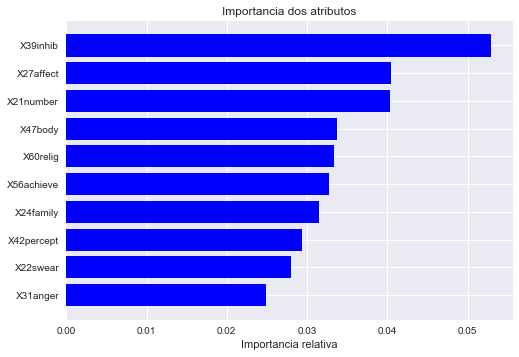

In [141]:
features = test_features.keys()
importances = model.feature_importances_

indices = np.argsort(importances)[-10:]

plt.title('Importancia dos atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importancia relativa')
plt.show()

## Neuroticism

In [142]:
%%time
model_trainer.fit(train_features, train_w2v_data['neuroticism'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 184 ms, sys: 128 ms, total: 312 ms
Wall time: 316 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [143]:
yp = model.predict(test_features)
yt = test_w2v_data['neuroticism']

In [144]:
skmetrics.mean_squared_error(yt, yp)

1.3946672676282053

In [145]:
skmetrics.r2_score(yt, yp)

-1.0030356129480764

In [146]:
skmetrics.mean_squared_error(yt, yp)**0.5

1.180960315856636

In [147]:
names = test_features.keys()
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.0355, 'aoa'), (0.0346, 'X37tentat'), (0.0288, 'X25friend'), (0.0268, 'X57leisure'), (0.0261, 'X13past'), (0.026, 'X43see'), (0.0252, 'X34insight'), (0.0239, 'X5we'), (0.0236, 'X21number'), (0.0234, 'X29negemo'), (0.0231, 'X44hear'), (0.023, 'X45feel'), (0.0229, 'X64filler'), (0.0227, 'X39inhib'), (0.0226, 'X12auxverb'), (0.0222, 'X14present'), (0.0218, 'X54time'), (0.0212, 'X26humans'), (0.0209, 'X28posemo'), (0.0203, 'X32sad'), (0.0197, 'X38certain'), (0.0196, 'X17preps'), (0.019, 'X33cogmech'), (0.0188, 'X58home'), (0.0183, 'X42percept'), (0.0178, 'X8they'), (0.0173, 'X7shehe'), (0.017, 'X1funct'), (0.0152, 'X40incl'), (0.0143, 'X22swear'), (0.0141, 'X52motion'), (0.014, 'X19negate'), (0.0134, 'X59money'), (0.0134, 'X15future'), (0.013, 'X61death'), (0.0123, 'X20quant'), (0.0122, 'subjective_freq'), (0.0122, 'X46bio'), (0.0122, 'X10article'), (0.0121, 'X6you'), (0.0121, 'X11verb'), (0.0114, 'X60relig'), (0.0112, 'X36discrep'), (0.0109, 'X41excl'), 

In [148]:
importances[indices][-10:]

array([ 0.02492416,  0.02795611,  0.02931815,  0.03143014,  0.03274878,
        0.03342005,  0.03368066,  0.04028682,  0.04051263,  0.05298594])

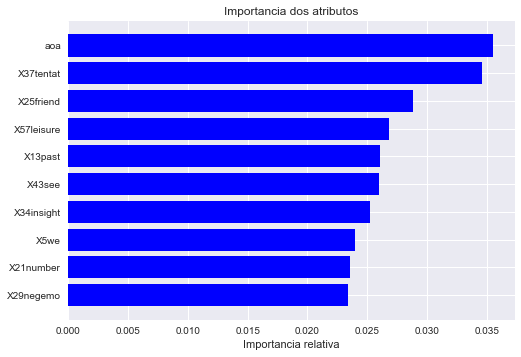

In [149]:
features = test_features.keys()
importances = model.feature_importances_

indices = np.argsort(importances)[-10:]

plt.title('Importancia dos atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices]) ## removed [indices]
plt.xlabel('Importancia relativa')
plt.show()

## Openess

In [150]:
%%time
model_trainer.fit(train_features, train_w2v_data['openness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 185 ms, sys: 121 ms, total: 306 ms
Wall time: 328 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [151]:
yp = model.predict(test_features)
yt = test_w2v_data['openness']

In [152]:
skmetrics.mean_squared_error(yt, yp)

0.83352864583333341

In [153]:
skmetrics.r2_score(yt, yp)

-1.2869175814636229

In [154]:
skmetrics.mean_squared_error(yt, yp)**0.5

0.9129778999698368

In [155]:
names = test_features.keys()
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.051, 'X47body'), (0.0498, 'imagery'), (0.0403, 'X22swear'), (0.0373, 'X43see'), (0.0334, 'X27affect'), (0.0329, 'X25friend'), (0.0288, 'X51relativ'), (0.0284, 'X62assent'), (0.027, 'aoa'), (0.0254, 'X64filler'), (0.024, 'X29negemo'), (0.024, 'X18conj'), (0.023, 'X39inhib'), (0.0227, 'X19negate'), (0.0219, 'X40incl'), (0.0219, 'X16adverb'), (0.0214, 'X61death'), (0.0201, 'X49sexual'), (0.0198, 'X26humans'), (0.0195, 'X36discrep'), (0.0189, 'X1funct'), (0.0173, 'X38certain'), (0.0172, 'X9ipron'), (0.0169, 'X10article'), (0.0167, 'X46bio'), (0.0165, 'X5we'), (0.0165, 'X59money'), (0.0156, 'concreteness'), (0.0151, 'X7shehe'), (0.0149, 'X23social'), (0.0147, 'X8they'), (0.0146, 'X60relig'), (0.0135, 'X54time'), (0.0133, 'X57leisure'), (0.0127, 'X20quant'), (0.0126, 'X53space'), (0.0124, 'X13past'), (0.0121, 'X55work'), (0.0114, 'X44hear'), (0.0109, 'X12auxverb'), (0.0108, 'X50ingest'), (0.0095, 'X17preps'), (0.0084, 'X32sad'), (0.0082, 'X33cogmech'), (0.

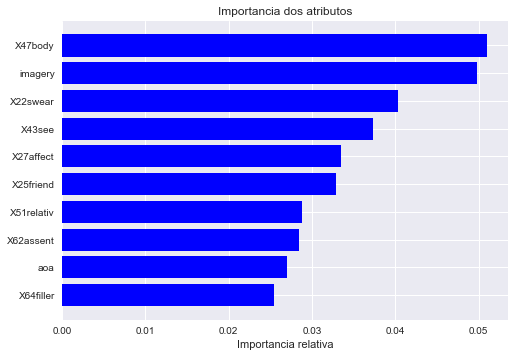

In [156]:
features = test_features.keys()
importances = model.feature_importances_

indices = np.argsort(importances)[-10:]

plt.title('Importancia dos atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importancia relativa')
plt.show()